In [ ]:
import parser
import json
import urllib
import pandas as pd
import imp
import numpy as np
import seaborn as sns
from tqdm import tqdm
import math

from sklearn.preprocessing import Imputer
from sklearn import ensemble
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score

from PIL import Image
import matplotlib.pyplot as plt
import imdb_movie_content
from collections import Counter
%matplotlib inline
imp.reload(parser)
imp.reload(imdb_movie_content)

ModuleNotFoundError: No module named 'tqdm'

In [35]:
df = parser.create_dataframe("movie_contents.json", "movie_budget.json")
df.set_index('movie_title', inplace=True, drop=False)
df.sort_index(inplace=True)
awards_columns = [col for col in df.columns if 'nominated' in col or 'won' in col]
df_awards = df[awards_columns]
awards_per_movie = (len(awards_columns) - df_awards.isnull().sum(axis=1)).to_dict()
df['nb_awards'] = df['movie_title'].map(awards_per_movie)
df = df.drop_duplicates(['movie_title'])
df = df.rename(columns = {'director_fb_links': 'director_fb_likes'})

## Awards and Gross

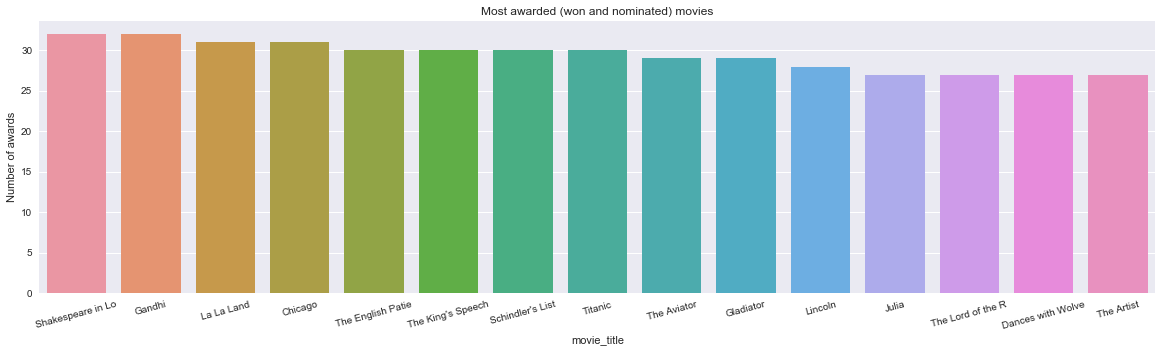

In [3]:
d = df['nb_awards'].sort_values(ascending=False)[:15]
plt.figure(figsize=(20,5))
plot = sns.barplot(x=d.index, y=d)
_ = plot.set_xticklabels([elem[:17] for elem in d.index], rotation=15)
_ = plot.set_title('Most awarded (won and nominated) movies')
_ = plot.set_ylabel('Number of awards')

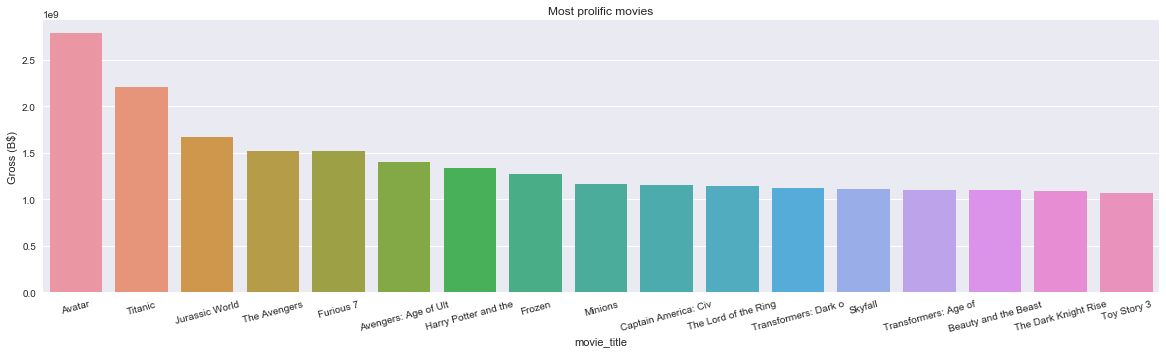

In [4]:
d = df.worldwide_gross.sort_values(ascending=False)[:17]
plt.figure(figsize=(20,5))
plot = sns.barplot(x=d.index, y=d)
_ = plot.set_xticklabels([elem[:20] for elem in d.index], rotation=15)
_ = plot.set_title('Most prolific movies')
_ = plot.set_ylabel('Gross (B$)')

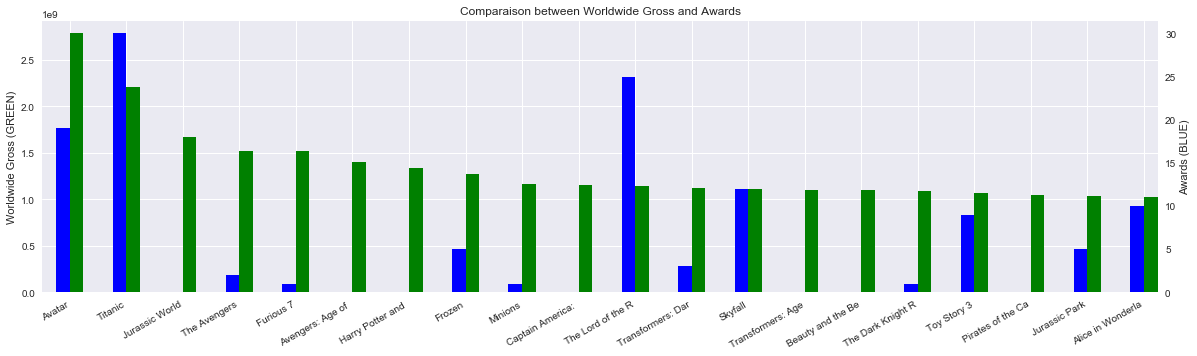

In [885]:
sns.set()

d = df.worldwide_gross.sort_values(ascending=False)[:20]
e = df_awards[df_awards.index.isin(d.index)].isnull().sum(axis=1)
e = len(awards_columns) - e[~e.index.duplicated(keep='first')].reindex(d.index)

margin = 0.05
width = 4*(1.-2.*margin)/15
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
d.plot(kind='bar', color='green', ax=ax, width=width, position=0)
e.plot(kind='bar', color='blue', ax=ax2, width=width, position=1)
ax.set_ylabel('Worldwide Gross (GREEN)')
ax2.set_ylabel('Awards (BLUE)')
ax.set_xlabel('')
ax.set_title('Comparaison between Worldwide Gross and Awards')
_ = ax.set_xticklabels([elem[:17] for elem in d.index], rotation = 30, ha='right')
ax2.grid(False)

## Facebook likes

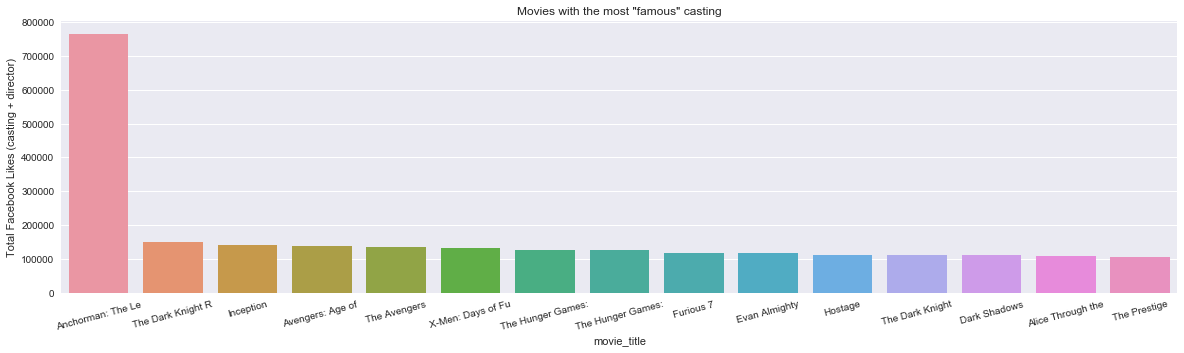

In [888]:
d = df['total_cast_fb_likes'].sort_values(ascending=False)[:15]
e = df[df.index.isin(d.index)].num_facebook_like
plt.figure(figsize=(20,5))
plot = sns.barplot(x=d.index, y=d)
_ = plot.set_xticklabels([elem[:17] for elem in d.index], rotation=15)
_ = plot.set_title('Movies with the most "famous" casting')
_ = plot.set_ylabel('Total Facebook Likes (casting + director)')

We would use the most correlated features in our estimator. We would likely use a Random forest (500 estimators).

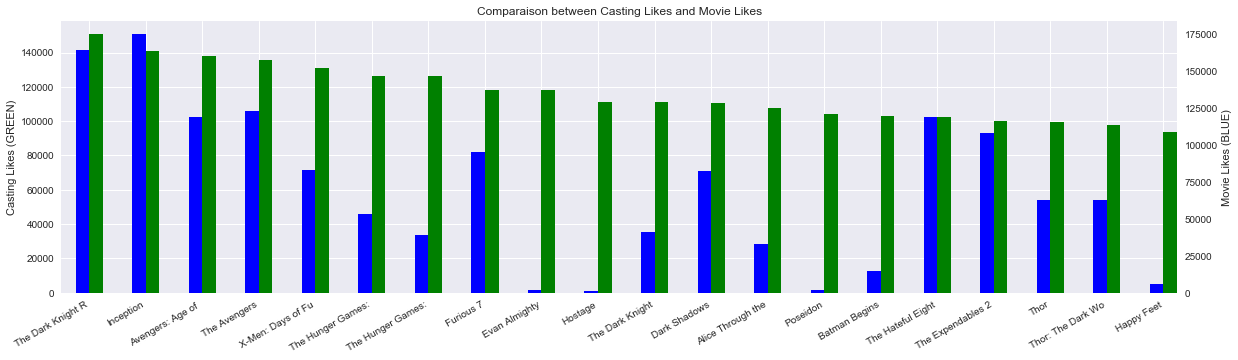

In [548]:
sns.set()

d = df['total_cast_fb_likes'].sort_values(ascending=False)[:20]
e = df[df.index.isin(d.index)].num_facebook_like.reindex(d.index)
margin = 0.05
width = 4*(1.-2.*margin)/15
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
d.plot(kind='bar', color='green', ax=ax, width=width, position=0)
e.plot(kind='bar', color='blue', ax=ax2, width=width, position=1)
ax.set_ylabel('Casting Likes (GREEN)')
ax2.set_ylabel('Movie Likes (BLUE)')
ax.set_xlabel('')
ax.set_title('Comparaison between Casting Likes and Movie Likes')
_ = ax.set_xticklabels([elem[:17] for elem in d.index], rotation = 30, ha='right')
ax2.grid(False)

## Best Actors

### Actor in movie

In [5]:
all_actors = [actor for actor in list(set(list(df.actor_1_name) + list(df.actor_2_name) + list(df.actor_3_name))) if pd.notnull(actor)]
imdb_score_per_actor = {}
for actor in all_actors:
    imdb_score_per_actor[actor] = df[(df.actor_1_name == actor) | (df.actor_2_name == actor) | (df.actor_3_name == actor)].idmb_score.mean()

In [6]:
millnames = ['',' K',' M',' B']
def millify(n):
    if pd.notnull(n):
        n = float(n)
        millidx = max(0,min(len(millnames)-1,
                            int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))
        return '{:.1f}{}'.format(n / 10**(3 * millidx), millnames[millidx])
    else:
        return n

In [7]:
gross_per_actor = {}
for actor in all_actors:
    gross_per_actor[actor] = df[(df.actor_1_name == actor) | (df.actor_2_name == actor) | (df.actor_3_name == actor)].worldwide_gross.mean()

In [9]:
mini_movie = 3
top_k = 3
best_mini_gross = sorted([(k,v) for k,v in sorted(gross_per_actor.items(), key=lambda x:x[1], reverse=True) if len(df[(df.actor_1_name == k) 
                                                                                                           | (df.actor_2_name == k) 
                                                                                                           | (df.actor_3_name == k)]) >= mini_movie], key=lambda x:x[1], reverse=True)[:20]

best_mini_gross_str = [elem[0]+ ', %s (%s movie.s)' % (millify(elem[1]),len(df[(df.actor_1_name == elem[0]) 
                                                   | (df.actor_2_name == elem[0]) 
                                                   | (df.actor_3_name == elem[0])])) for elem in best_mini_gross][:top_k]

best_mini = [(k,v) for k,v in sorted(imdb_score_per_actor.items(), key=lambda x:x[1], reverse=True) if len(df[(df.actor_1_name == k) 
                                                                                                   | (df.actor_2_name == k) 
                                                                                                   | (df.actor_3_name == k)]) >= mini_movie][:20]

best_mini_str = [elem[0]+ ', %s (%s movie.s)' % (round(elem[1], 2),len(df[(df.actor_1_name == elem[0]) 
                                                   | (df.actor_2_name == elem[0]) 
                                                   | (df.actor_3_name == elem[0])])) for elem in best_mini][:top_k]

In [10]:
print('The {} best actors are (with minimum {} movies) : \n{}'.format(top_k, mini_movie,
       '\n'.join(best_mini_str)))

print('\nThe {} most prolific actors are (with minimum {} movies) : \n{}'.format(top_k, mini_movie,
       '\n'.join(best_mini_gross_str)))

The 3 best actors are (with minimum 3 movies) : 
Mark Hamill, 8.63 (3 movie.s)
Michael Biehn, 8.0 (3 movie.s)
Cate Blanchett, 7.82 (8 movie.s)

The 3 most prolific actors are (with minimum 3 movies) : 
Richard Armitage, 825.8 M (4 movie.s)
Rupert Grint, 701.6 M (5 movie.s)
Orlando Bloom, 682.8 M (7 movie.s)


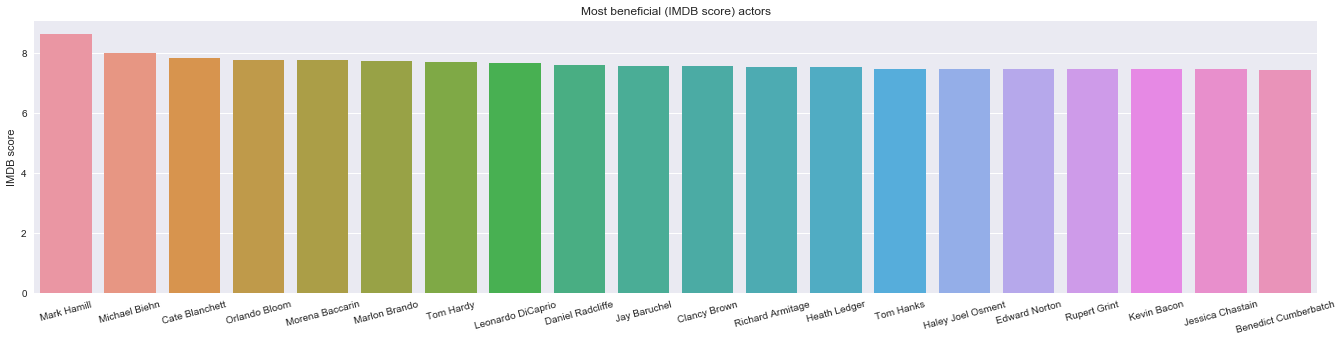

In [11]:
plt.figure(figsize=(23,5))

plot = sns.barplot([elem[0] for elem in best_mini], [elem[1] for elem in best_mini])
_ = plot.set_xticklabels([elem[0] for elem in best_mini], rotation=15)
_ = plot.set_title('Most beneficial (IMDB score) actors')
_ = plot.set_ylabel('IMDB score')

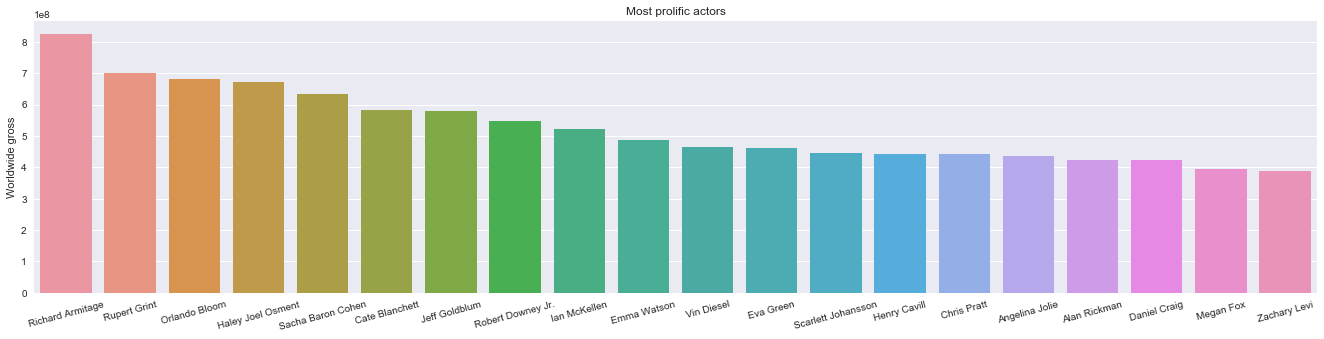

In [12]:
plt.figure(figsize=(23,5))
plot = sns.barplot([elem[0] for elem in best_mini_gross], [elem[1] for elem in best_mini_gross])
_ = plot.set_xticklabels([elem[0] for elem in best_mini_gross], rotation=15)
_ = plot.set_title('Most prolific actors')
_ = plot.set_ylabel('Worldwide gross')

### First star in movie

In [553]:
big_star = df.groupby(['actor_1_name'])['idmb_score', 'worldwide_gross'].mean().sort_values(['idmb_score', 'worldwide_gross'], ascending=False)
big_star['nb_movies'] = big_star.index
big_star['nb_movies'] = big_star['nb_movies'].map(df.groupby(['actor_1_name'])['movie_title'].count().to_dict())
big_star['worldwide_gross'] = big_star['worldwide_gross'].apply(millify)
top_k = 7
print('The {} best actors as most famous actor are :'.format(top_k))
big_star[big_star.nb_movies >= 3].head(top_k)

The 7 best actors as most famous actor are :


,idmb_score,worldwide_gross,nb_movies
actor_1_name,,,
Leonardo DiCaprio,8.122222,398.5 M,9
Matthew McConaughey,7.800000,255.5 M,3
Tom Hanks,7.787500,411.4 M,8
Richard Armitage,7.733333,977.5 M,3
Christopher Lee,7.475000,557.7 M,4
Daniel Craig,7.400000,422.9 M,4
Tom Hardy,7.350000,403.9 M,4


In [521]:
big_star = df.groupby(['actor_1_name'])['idmb_score', 'worldwide_gross'].mean().sort_values(['worldwide_gross', 'idmb_score'], ascending=False)
big_star['nb_movies'] = big_star.index
big_star['nb_movies'] = big_star['nb_movies'].map(df.groupby(['actor_1_name'])['movie_title'].count().to_dict())
big_star['worldwide_gross'] = big_star['worldwide_gross'].apply(millify)
top_k = 7
print('The {} most prolific actors as most famous actor are :'.format(top_k))
big_star[big_star.nb_movies >= 3].head(top_k)

The 7 most prolific actors as most famous actor are :


,idmb_score,worldwide_gross,nb_movies
actor_1_name,,,
Richard Armitage,7.733333,977.5 M,3
Robert Pattinson,5.675000,763.5 M,4
Chris Hemsworth,7.083333,751.6 M,6
Jennifer Lawrence,7.200000,621.7 M,8
J.K. Simmons,6.925000,605.8 M,8
Angelina Jolie,7.075000,586.5 M,4
Henry Cavill,6.600000,582.6 M,3


## IMDB rating and other variables

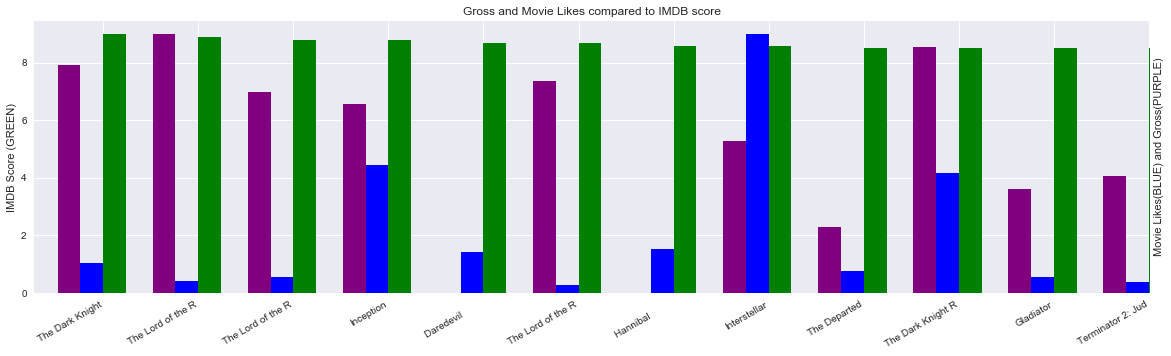

In [249]:
d = df['idmb_score'].apply(float).sort_values(ascending=False)[:12]
e = df[df.index.isin(d.index)].num_facebook_like.reindex(d.index)
f = df[df.index.isin(d.index)].worldwide_gross.reindex(d.index)
margin = 0.05
width = 4*(1.-2.*margin)/15
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax3= ax2.twinx()
d.plot(kind='bar', color='green', ax=ax, width=width, position=0)
e.plot(kind='bar', color='blue', ax=ax2, width=width, position=1)
f.plot(kind='bar', color='purple', ax=ax3, width=width, position=2)
ax.set_ylabel('IMDB Score (GREEN)')
ax2.set_ylabel('Movie Likes(BLUE) and Gross(PURPLE)')
ax3.set_yticklabels('')
ax2.set_yticklabels('')
ax.set_xlabel('')
_ = ax.set_xticklabels([elem[:17] for elem in d.index], rotation = 30, ha='right')
ax3.grid(False)
ax2.grid(False)
ax.set_title('Gross and Movie Likes compared to IMDB score')

,nb_awards,domestic_gross,worldwide_gross,total_cast_fb_likes,director_fb_likes,production_budget,num_critic_for_reviews,idmb_score,actor_1_fb_likes,actor_2_fb_likes,actor_3_fb_likes
nb_awards,1.000000,0.256910,0.232643,0.129949,0.256985,0.046063,0.261310,0.413660,0.041738,0.161491,0.147963
domestic_gross,0.256910,1.000000,0.935842,0.277702,0.176098,0.649957,0.483601,0.263081,0.079222,0.324051,0.368906
worldwide_gross,0.232643,0.935842,1.000000,0.277677,0.164262,0.724943,0.517116,0.245807,0.066839,0.339250,0.396354
total_cast_fb_likes,0.129949,0.277702,0.277677,1.000000,0.280496,0.305823,0.360474,0.218539,0.873110,0.632069,0.641536
director_fb_likes,0.256985,0.176098,0.164262,0.280496,1.000000,0.128954,0.243488,0.264821,0.069803,0.204641,0.249485
production_budget,0.046063,0.649957,0.724943,0.305823,0.128954,1.000000,0.489272,0.087965,0.096173,0.367139,0.419698
num_critic_for_reviews,0.261310,0.483601,0.517116,0.360474,0.243488,0.489272,1.000000,0.346106,0.126010,0.451665,0.469634
idmb_score,0.413660,0.263081,0.245807,0.218539,0.264821,0.087965,0.346106,1.000000,0.101598,0.230435,0.232669
actor_1_fb_likes,0.041738,0.079222,0.066839,0.873110,0.069803,0.096173,0.126010,0.101598,1.000000,0.284472,0.250632
actor_2_fb_likes,0.161491,0.324051,0.339250,0.632069,0.204641,0.367139,0.451665,0.230435,0.284472,1.000000,0.815911


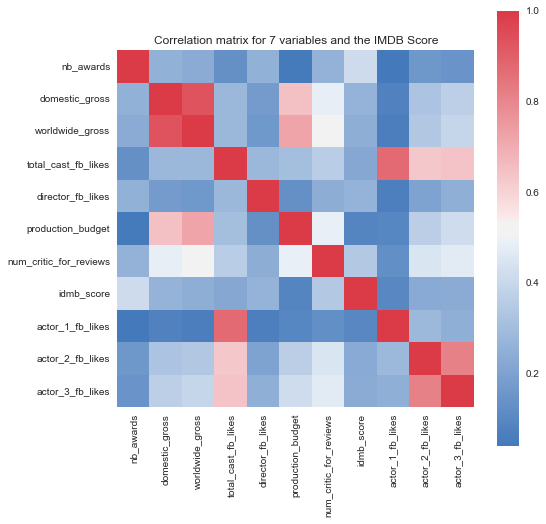

In [14]:
# Correlation Matrix

corr = df[['nb_awards', 'domestic_gross','worldwide_gross', 
    'total_cast_fb_likes','director_fb_likes', 'production_budget',
    'num_critic_for_reviews', 'idmb_score', 'actor_1_fb_likes', 'actor_2_fb_likes', 'actor_3_fb_likes']].corr()

plt.figure(figsize=(8,8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(250, 10, as_cmap=True),
            square=True)
plt.title('Correlation matrix for 7 variables and the IMDB Score')
corr

- As we can see in the pictures above, the imdb score is correlated to the number of awards and the gross but not really to the production budget and the number of facebook likes of the casting.  
- Obviously, domestic and worlwide gross are highly correlated. However, the more important the production budget, the more important the gross.  
- As it is shown in the notebook, the budget is not really correlated to the number of awards.  What's funny is that the popularity of the third most famous actor is more important for the IMDB score than the popularity of the most famous score (Correlation 0.2 vs 0.08).

## Genres

In [15]:
with open('genre.json', 'r') as f:
    genres = json.load(f)

In [16]:
imdb_score_per_genre = {}
gross_per_genre = {}
genre_columns = [col for col in df.columns if 'genre_' in col]
df_genres = df[genre_columns]
for genre, value in genres.items():
    mask = np.column_stack([df_genres[col] == value for col in df_genres])
    df_specific_genre = df.loc[mask.any(axis=1)][['genres', 'idmb_score', 'worldwide_gross']]
    imdb_score_per_genre[genre] = df_specific_genre.idmb_score.mean()
    gross_per_genre[genre] = df_specific_genre.worldwide_gross.mean()
gross_per_genre = {k:v for k,v in gross_per_genre.items() if pd.notnull(v)}

In [17]:
top_k = 5
print('The {} best genres (in terms of IMDB score) are : \n{}'.format(top_k, 
       '\n'.join(['%s (%s)' % (elem[0], round(elem[1], 1)) for elem in sorted(imdb_score_per_genre.items(), key=lambda x:x[1], reverse=True)][:top_k])))

print('\nThe {} most prolific genres are  : \n{}'.format(top_k, 
       '\n'.join(['%s (%s)' % (elem[0], millify(elem[1])) for elem in sorted(gross_per_genre.items(), key=lambda x:x[1], reverse=True)][:top_k])))

The 5 best genres (in terms of IMDB score) are : 
Biography (7.2)
History (7.1)
Drama (7.0)
Mystery (7.0)
War (7.0)

The 5 most prolific genres are  : 
Fantasy (457.7 M)
Adventure (454.7 M)
Animation (441.1 M)
Sci-Fi (433.0 M)
Musical (425.0 M)


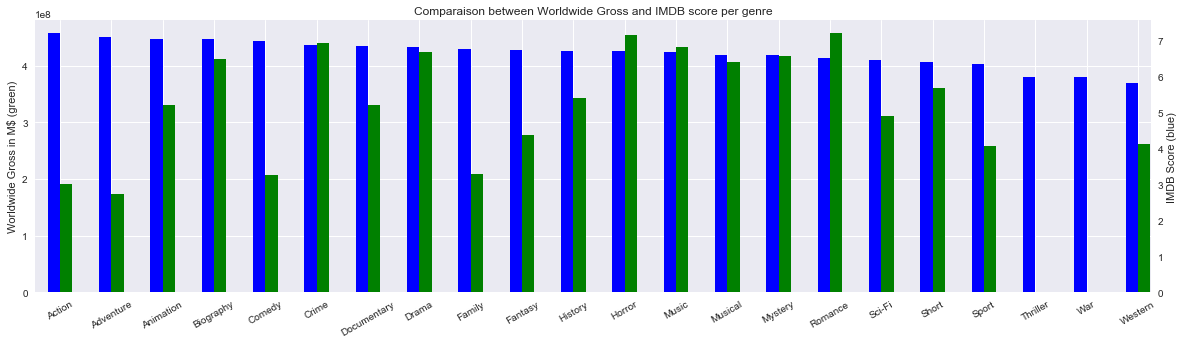

In [18]:
margin = 0.05
width = 4*(1.-2.*margin)/15
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()

df_combine = pd.concat([pd.Series(gross_per_genre), pd.Series(imdb_score_per_genre)], axis=1)
df_combine = df_combine.sort_values(1, ascending=False)
df_combine.columns = ['Gross', 'Score']

df_combine.Gross.plot(kind='bar', color='green', ax=ax, width=width, position=0)
df_combine.Score.plot(kind='bar', color='blue', ax=ax2, width=width, position=1)
ax.set_ylabel('Worldwide Gross in M$ (green)')
ax2.set_ylabel('IMDB Score (blue)')
ax.set_xlabel('')
ax.set_title('Comparaison between Worldwide Gross and IMDB score per genre')
_ = ax.set_xticklabels(pd.Series(imdb_score_per_genre).index, rotation = 30)
ax2.grid(False)

## Prediction

### Preprocessing

In [36]:
## Fill NA for genres
df.genres  = df.genres.fillna('')

## Mean Inputer
col_to_impute = ['actor_1_fb_likes', 'actor_2_fb_likes', 'actor_3_fb_likes',
                'domestic_gross', 'duration_sec', 'num_critic_for_reviews', 'num_facebook_like', 'num_user_for_reviews',
                'production_budget', 'total_cast_fb_likes', 'worldwide_gross', 'director_fb_likes']
for col in col_to_impute:
    column = np.array(df[col]).reshape(1, -1)
    imp = Imputer(missing_values='NaN', strategy='mean', axis=1)
    df[col] = imp.fit_transform(column)[0]

In [37]:
numerical_cols = list(df.dtypes[df.dtypes != 'object'].index)
not_wanted_cols = ['title_year', 'storyline', 'release_date', 'image_urls', 'movie_title', 'keywords', 'movie_imdb_link', 'num_voted_users'] + genre_columns
df.country = df.country.apply(lambda x:x.split('|'))
df.language = df.language.apply(lambda x:x.split('|'))
list_cols = ['country', 'genres', 'language']
cols_to_transform = [cols for cols in df.columns if cols not in numerical_cols + not_wanted_cols + list_cols]
df2 = df[cols_to_transform]

In [38]:
## Dummies for columns with list
df_col_list = pd.DataFrame()
for col in list_cols:
    df_col_list = pd.concat([df_col_list, pd.get_dummies(df[col].apply(pd.Series).stack()).sum(level=0)], axis=1)

In [39]:
## Dummies for columns with string
df_col_string = pd.get_dummies(df2, columns=cols_to_transform)

In [40]:
X_raw = pd.concat([df[numerical_cols], df_col_string, df_col_list], axis=1)
print('Columns dtypes :', Counter(X_raw.dtypes))

Columns dtypes : Counter({dtype('uint8'): 13004, dtype('float64'): 13, dtype('int64'): 1})


In [41]:
y = list(X_raw.idmb_score)
X = X_raw.drop('idmb_score', axis=1)

In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)
print('Train', X_train.shape, 'Test', X_test.shape)

Train (4089, 13017) Test (1023, 13017)


### Choosing ML algorithm

In [696]:
gbr = ensemble.GradientBoostingRegressor(n_estimators=1000)
gbr.fit(X_train,Y_train)
print ("Training Score GradientBoosting: ", str(gbr.score(X_train,Y_train)))
print ("Test Score GradientBoosting: " , str(gbr.score(X_test,Y_test)))

Training Score GradientBoosting:  0.965677058186
Test Score GradientBoosting:  0.445847202544


In [748]:
abr = ensemble.AdaBoostRegressor(n_estimators=10, learning_rate=0.4, loss='linear')
abr.fit(X_train,Y_train)
print ("Training Score AdaBoostRegressor: ", str(abr.score(X_train,Y_train)))
print ("Test Score AdaBoostRegressor: " , str(abr.score(X_test,Y_test)))

Training Score AdaBoostRegressor:  0.497750738605
Test Score AdaBoostRegressor:  0.450030379927


In [765]:
rf=ensemble.RandomForestRegressor(n_estimators=500,oob_score=True, ) 
rf.fit(X,y)
print ("Training Score RandomForest: ", str(rf.score(X,y)))
print ("Cross Validation (10 fold) Score: " , np.mean(cross_val_score(rf, X_train, Y_train, cv=10)))

Training Score RandomForest:  0.933556405649
OOB Score RandomForest:  0.514455022206


### Tuning

#### Cross Validation to choose n_estimators

In [45]:
rfs = {}
for k in [10, 20, 50, 70, 100, 120, 150, 200]:
    rf=ensemble.RandomForestRegressor(n_estimators=k, oob_score=True) 
    rf.fit(X,y)
    rfs[k] = np.mean(cross_val_score(rf, X_train, Y_train, cv=5))

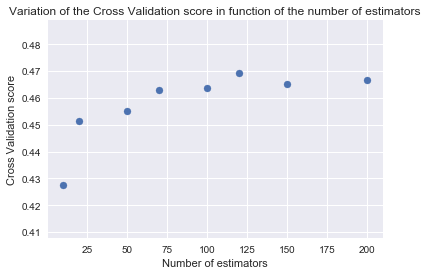

In [44]:
x_plot = list(rfs.keys())
y_plot = list(rfs.values())

f, ax = plt.subplots()
ax.scatter(x_plot, y_plot)
ax.set_title('Variation of the Cross Validation score in function of the number of estimators')
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Cross Validation score')

#### Min leaf

In [66]:
rfs2 = {}
for k in tqdm(list(range(1, 11, 2))+list(range(11,25,4))):
    rf = ensemble.RandomForestRegressor(n_estimators=120, oob_score=True, min_samples_leaf=k) 
    rf.fit(X,y)
    rfs2[k] = rf.oob_score_

100%|██████████| 9/9 [20:01<00:00, 131.78s/it]


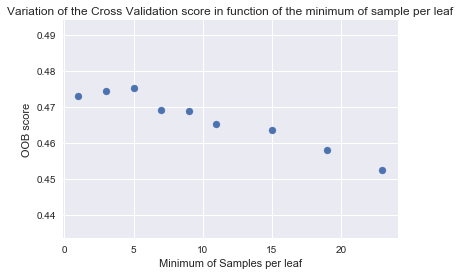

In [69]:
x_plot = list(rfs2.keys())
y_plot = list(rfs2.values())

f, ax = plt.subplots()
ax.scatter(x_plot, y_plot)
ax.set_title('Variation of the Cross Validation score in function of the minimum of sample per leaf')
ax.set_xlabel('Minimum of Samples per leaf')
ax.set_ylabel('OOB score')

#### max_features

In [61]:
rfs2 = {}
for k in ["log2", "auto", "sqrt", 0.2, 0.1, 0.3] :
    rf = ensemble.RandomForestRegressor(n_estimators=120, oob_score=True, min_samples_leaf= 1, max_features = k) 
    rf.fit(X,y)
    rfs2[k] = rf.oob_score_

[0.2, 0.1, 0.3, 'log2', 'auto', 'sqrt']


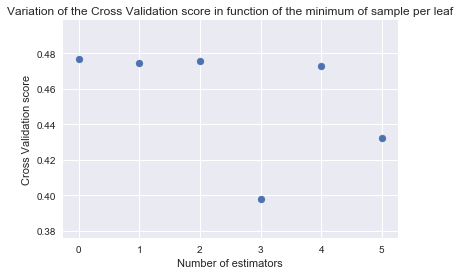

In [62]:
x_plot = range(len(rfs2))# list(rfs2.keys())
y_plot = list(rfs2.values())
print(list(rfs2.keys()))
f, ax = plt.subplots()
ax.scatter(x_plot, y_plot)
ax.set_title('Variation of the Cross Validation score in function of the minimum of sample per leaf')
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Cross Validation score')

### Learning

In [70]:
rf = ensemble.RandomForestRegressor(n_estimators=120, oob_score=True, max_features=0.2, min_samples_leaf=5) 
rf.fit(X,y)
print ("Training Score RandomForest: ", str(rf.score(X,y)))
print ("OOB Score RandomForest: " , str(rf.oob_score_))

Training Score RandomForest:  0.676602290011
OOB Score RandomForest:  0.472550704314


### Most important features

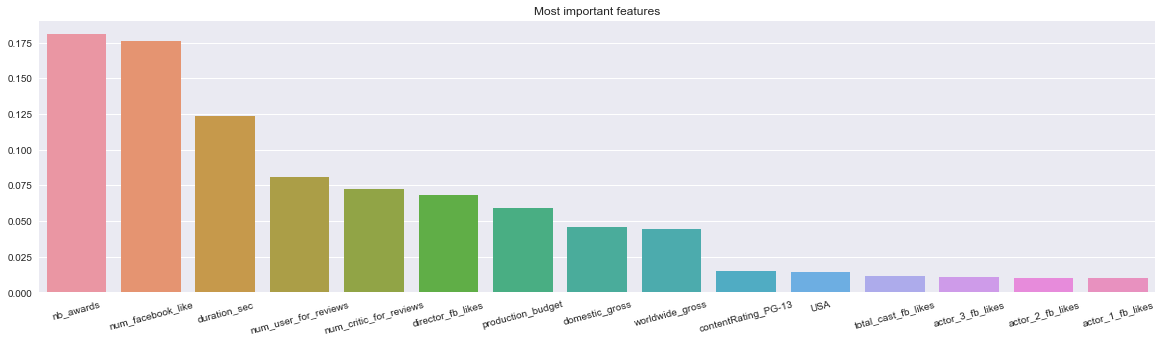

In [71]:
top_k = 15
plt.figure(figsize=(20,5))
names = X_train.columns[np.argsort(rf.feature_importances_)[::-1][:top_k]]
values = np.sort(rf.feature_importances_)[::-1][:top_k]
plot = sns.barplot(x = names, y = values, order=names)
_ = plot.set_xticklabels(names, rotation=15)
_ = plot.set_title('Most important features')